### Import the necessary packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TextClassificationPipeline 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
import mlflow
from mlflow.transformers import log_model
import logging 
import torch
from torch.nn import CrossEntropyLoss



from sklearn.model_selection import train_test_split
import pickle
import warnings
warnings.filterwarnings('ignore') 
from mlflow.sklearn import save_model 
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # This tells Hugging Face: “Don’t use parallel tokenization — avoid possible deadlocks.”

import seaborn as sns
import matplotlib.pyplot as plt

import config 


# tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
# model = AutoModelForMaskedLM.from_pretrained("distilbert/distilbert-base-uncased")

/Users/alicepope/Capstone project/Capstone_project/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_NAME = "distilbert-base-uncased" # pulls the general-purpose DistilBERT model
DATA_PATH = "../data/data_small.csv"
TRACKING_URI = config.TRACKING_URI #??? TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

In [3]:
# Load and preprocess data
logger.info("Loading and preprocessing data...")
df = pd.read_csv(DATA_PATH)

# use only 10 rows to test end-to-end run (comment this line out later)
df = df.sample(10, random_state=42).reset_index(drop=True)

le = LabelEncoder()
df["label"] = le.fit_transform(df["logical_fallacies"])
dataset = Dataset.from_pandas(df[["text", "label"]])
dataset = dataset.train_test_split(test_size=0.3)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

dataset = dataset.map(tokenize, batched=True)

2025-04-03 10:17:08,756: Loading and preprocessing data...
Map: 100%|██████████| 3/3 [00:00<00:00, 381.68 examples/s]


In [4]:
# Initialize model, we should use AutoModelForSequenceClassification and not AutoModelForMaskedLM because we are doing classification
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(le.classes_))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# To see a summary of the model
print(model.config)

DistilBertConfig {
  "_attn_implementation_autoset": true,
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.50.3",
  "vocab_size": 30522
}



In [ ]:
# # Get labels from training set
# y_train = dataset["train"]["label"]
# # all_labels = list(range(len(le.classes_))) 
# present_labels = np.unique(y_train)

# # Compute class weights
# class_weights = compute_class_weight(class_weight='balanced', classes=present_labels, y=y_train)
# class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [24]:

# Get full list of label indices
full_class_indices = np.arange(len(le.classes_))  # e.g., [0, 1, 2, 3, 4, 5]

# Get only the classes that appear in y_train
y_train = dataset["train"]["label"]
present_classes = np.unique(y_train)

# Compute weights ONLY for the present ones
present_weights = compute_class_weight(
    class_weight="balanced",
    classes=present_classes,
    y=y_train
)

# Initialize full weight vector with 0s, then insert the computed ones
full_weights = np.zeros(len(full_class_indices), dtype=np.float32)
for idx, cls in enumerate(present_classes):
    full_weights[cls] = present_weights[idx]

# Convert to tensor
class_weights_tensor = torch.tensor(full_weights, dtype=torch.float)


In [25]:
# Hugging Face’s Trainer does not support class weights out-of-the-box, so we must override the loss

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs): # **kwargs captures unexpected/optional arguments (like num_items_in_batch) without breaking your function
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor.to(model.device))
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [26]:
# Define metric logging function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="macro")
    recall = recall_score(labels, preds, average="macro")
    f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [27]:
# TrainingArguments This config tells the Trainer: 
# “Train for 3 epochs, evaluate and save the model after each one, 
# use moderate batch sizes, 
# and keep logs and checkpoints local — don’t auto-report to external dashboards.” --> can it be set to report to MLFlow?

args = TrainingArguments(
    output_dir="fallacy-model",
    learning_rate=3e-5, # added for fine-tuning, 5e-5 by default
    weight_decay=0.01,  # added for fine-tuning, 0 by default
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=4,  # increased from 3 for fine-tuning
    logging_dir="./logs",
    save_strategy="epoch",
    report_to="none"
)

In [ ]:
# Train using Trainer and log to MLflow
# setting the MLFlow connection and experiment

params = {
      "learning_rate": 3e-5,
      "weight_decay": 0.01,
      "num_train_epochs": 4,
      "evaluation_strategy": "epoch",
  }


# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)


with mlflow.start_run():
    run = mlflow.active_run()
    print("Active run_id: {}".format(run.info.run_id))
    mlflow.set_tag("model_name", MODEL_NAME)
    mlflow.log_params(params)
    trainer = WeightedTrainer(
        model=model,
        args=args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()
    trainer.evaluate()

    # Wrap model in a Hugging Face pipeline so MLflow can log it properly
    pipeline = TextClassificationPipeline(model=trainer.model, tokenizer=tokenizer)
    log_model(pipeline, artifact_path="model") 

# Even though with mlflow.start_run(): handles ending automatically, it's good style to include the end
mlflow.end_run()

# to inspect the run after it finishes
mlflow.get_run(run_id=run.info.run_id)


Active run_id: 6134a29fcd9441ff81bbad7209de45f9


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.361869,0.000000,0.000000,0.000000,0.000000
2,No log,1.349172,0.000000,0.000000,0.000000,0.000000
3,No log,1.342854,0.000000,0.000000,0.000000,0.000000
4,No log,1.339488,0.000000,0.000000,0.000000,0.000000


Device set to use cpu
2025/04/03 10:30:45 WARNING mlflow.transformers.signature: An unsupported task type was supplied for signature inference. Either provide an `input_example` or generate a signature manually via `infer_signature` to have a signature recorded in the MLmodel file.
2025/04/03 10:31:08 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/qt/8rxmyyc907sdnc599f4rg0080000gn/T/tmpw4m84xoj/model, flavor: transformers). Fall back to return ['transformers==4.50.3', 'torch==2.2.2', 'torchvision==0.17.2', 'accelerate==1.5.2']. Set logging level to DEBUG to see the full traceback. 
2025/04/03 10:31:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


<Run: data=<RunData: metrics={}, params={'evaluation_strategy': 'epoch',
 'learning_rate': '3e-05',
 'num_train_epochs': '3',
 'weight_decay': '0.01'}, tags={'mlflow.log-model.history': '[{"run_id": "6134a29fcd9441ff81bbad7209de45f9", '
                             '"artifact_path": "model", "utc_time_created": '
                             '"2025-04-03 08:30:43.750501", "model_uuid": '
                             '"a1ff9e82a89948f9ba07e185f0421c41", "flavors": '
                             '{"transformers": {"transformers_version": '
                             '"4.50.3", "code": null, "task": "", '
                             '"instance_type": "TextClassificationPipeline", '
                             '"framework": "pt", "torch_dtype": '
                             '"torch.float32", "pipeline_model_type": '
                             '"DistilBertForSequenceClassification", '
                             '"source_model_name": "distilbert-base-uncased", '
                    

                       precision    recall  f1-score   support

           ad_hominem       0.72      0.61      0.66       157
  appeal_to_authority       0.63      0.61      0.62        92
    appeal_to_emotion       0.74      0.71      0.72       219
        false_dilemma       0.72      0.67      0.69       134
faulty_generalization       0.60      0.56      0.58       197
                 none       0.80      0.86      0.83       701

             accuracy                           0.74      1500
            macro avg       0.70      0.67      0.68      1500
         weighted avg       0.74      0.74      0.74      1500

Confusion Matrix:
[[ 96   6  23   5   6  21]
 [  7  56   5   0   6  18]
 [ 11   5 156   4  13  30]
 [  3   3   7  90   7  24]
 [  9   4   7   5 111  61]
 [  7  15  14  21  43 601]]


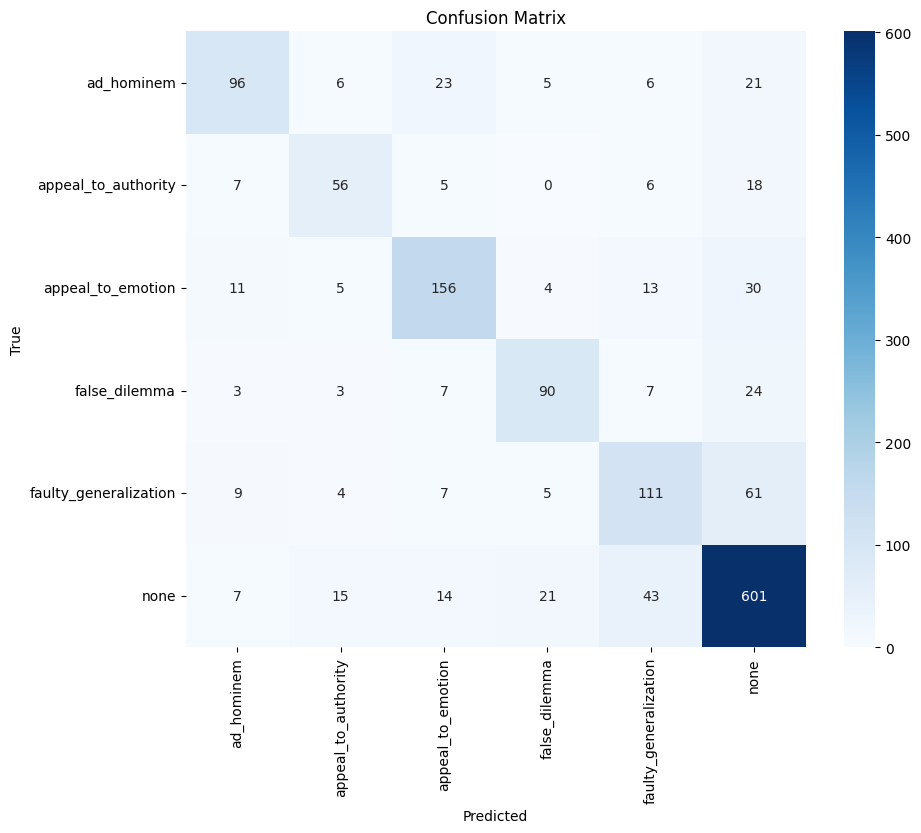

In [24]:
# Add prediction and reporting here
output = trainer.predict(dataset["test"])
predictions = np.argmax(output.predictions, axis=1)
y_true = output.label_ids

# Classification report
label_names = le.classes_
print(classification_report(y_true, predictions, target_names=label_names))

# Confusion matrix
cm = confusion_matrix(y_true, predictions)
print("Confusion Matrix:")
print(cm)

# plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
path = "../models/DistilBert"
save_model(sk_model=model, path=path)

2025/04/02 17:00:46 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [ ]:
# To optimize: 

# 1. modify learning rate, epochs, and weights --> What is the default? epoch, I set to 3

# 2. Give higher weight to classes with fewer examples